# SVM Notebook

In [5]:
### modules
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import Union, Optional

### Trainingsdaten

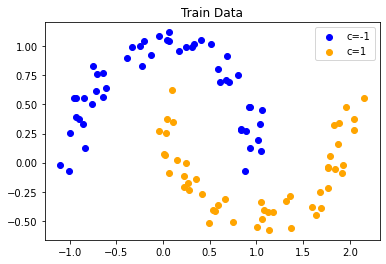

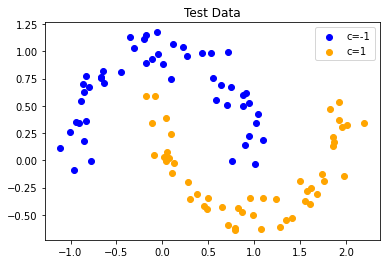

In [6]:
train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
train_labels[train_labels == 0] = -1 

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
test_labels[test_labels == 0] = -1

plt.figure()
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.figure()
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels == -1, 0], y=test_samples[test_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels == 1, 0], y=test_samples[test_labels == 1, 1], label="c=1", c="orange")
plt.legend()

## 1. SVM mit Kernel

CVXPY wird zur Lösung der Wolfe Dual genutzt.

In [7]:
import cvxpy as cp

def solve_qp(Q: np.ndarray, q: np.ndarray,
             G:np.ndarray, h: Union[np.ndarray, float],
             A:np.ndarray, b: Union[np.ndarray, float]) -> np.ndarray:
    """
    solves quadratic problem: min_x  0.5x^T Q x + q.^T x s.t. Gx <= h and Ax = b
      in the following 'dim' refers to the dimensionality of the optimization variable x
    :param Q: matrix of the quadratic term of the objective, (shape [dim, dim])
    :param q: vector for the linear term of the objective, (shape [dim])
    :param G: factor for lhs of the inequality constraint (shape [dim], or [dim, dim])
    :param h: rhs of the inequality constraint (shape [dim], or scalar)
    :param A: factor for lhs of the equality constraint (shape [dim], or [dim, dim])
    :param b: rhs of the equality constraint (shape [dim], or scalar)
    :return: optimal x (shape [dim])
    """
    x = cp.Variable(q.shape[0])
    prob = cp.Problem(cp.Minimize(0.5 * cp.quad_form(x, Q) + q.T @ x), constraints=[G @ x <= h, A @ x == b])
    prob.solve()
    return x.value

Kernel definieren und Funktionen zur Konstruktion und Ausführung der SVM zur Verfügung stellen.

In [8]:

def get_gaussian_kernel_matrix(x: np.ndarray, sigma: float, y: Optional[np.ndarray] = None) -> np.ndarray:
    """ Computes Kernel matrix K(x,y) between two sets of data points x, y  for a Gaussian Kernel with bandwidth sigma.
    If y is not given it is assumed to be equal to x, i.e. K(x,x) is computed
    :param x: matrix containing first set of points (shape: [N, data_dim])
    :param sigma: bandwidth of gaussian kernel
    :param y: matrix containing second set of points (shape: [M, data_dim])
    :return: kernel matrix K(x,y) (shape [M, N])
    """
    if y is None:
        y = x
    result = np.zeros((y.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            result[j,i] = np.dot(x[i]-y[j], x[i]-y[j])
    return np.exp(-sigma**(-2) * result)



def fit_svm(samples: np.ndarray, labels: np.ndarray, sigma: float) -> np.ndarray:
    """
    fits an svm (with Gaussian Kernel)
    :param samples: samples to fit the SVM to (shape: [N, data_dim])
    :param labels: class labels corresponding to samples (shape: [N])
    :param sigma: bandwidth of gaussian kernel
    :return: "alpha" values, weight for each datapoint in the dual formulation of SVM (shape [N])
    """
    N = labels.shape[0]
    Q = get_gaussian_kernel_matrix(samples, sigma) * (labels @ labels.T)
    q = -1 * np.ones((N)).T
    A = labels.T
    b = 0
    G = (-1) * np.identity(N)
    h = np.zeros((N)).T
    return solve_qp(Q,q,G,h,A,b)



def predict_svm(samples_query: np.ndarray, samples_train: np.ndarray, labels_train: np.ndarray,
                alphas: np.ndarray, sigma: float) -> np.ndarray:
    """
    predict labels for query samples given training data and weights
    :param samples_query: samples to query (i.e., predict labels) (shape: [N_query, data_dim])
    :param samples_train: samples that where used to train svm (shape: [N_train, data_dim])
    :param labels_train: labels corresponding to samples that where used to train svm (shape: [N_train])
    :param alphas: alphas computed by training procedure (shape: [N_train])
    :param sigma: bandwidth of gaussian kernel
    :return: predicted labels for query points (shape: [N_query])
    """
    return np.sign((alphas * labels_train) @ get_gaussian_kernel_matrix(samples_query,sigma,y=samples_train))

Visualisierung

Train Accuracy:  1.0
Test Accuracy:  0.99


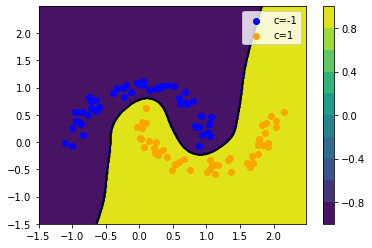

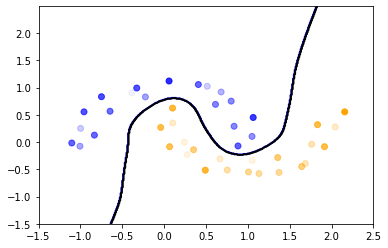

In [9]:
sigma = 0.3

# train
alphas = fit_svm(train_samples, train_labels, sigma)

# evaluate 
train_predictions = predict_svm(train_samples, train_samples, train_labels, alphas, sigma)
test_predictions = predict_svm(test_samples, train_samples, train_labels, alphas, sigma)

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

# plot train, contour, decision boundary and margins 
plt.figure()
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(predict_svm(flat_plt_grid, train_samples, train_labels, alphas, sigma), plt_grid_shape)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)

plt.colorbar()

plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

# plot margin, decision boundary and support vectors
plt.figure()
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))

# squeeze alpha values into interval [0, 1] for plotting
alphas_plt = np.clip(alphas / np.max(alphas), a_min=0.0, a_max=1.0)
for label, color in zip([-1, 1], ["blue", "orange"]):
    color_rgb = colors.to_rgb(color)
    samples = train_samples[train_labels == label]
    color_rgba = np.zeros((len(samples), 4))
    color_rgba[:, :3] = color_rgb
    color_rgba[:, 3] = alphas_plt[train_labels == label]
    plt.scatter(x=samples[:, 0], y=samples[:, 1], c=color_rgba)


plt.xlim(-1.5, 2.5)
plt.show()

## 2. SVM mit Hinge-loss